## Importing libraries

In [10]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from PIL import ImageDraw
import torch
import torchvision.transforms.functional as tf
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
from torchinfo import summary
from torchvision.ops import box_iou
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
plt.style.use('ggplot')

## Data Loading

In [12]:
dataset = load_dataset("keremberke/license-plate-object-detection", "full")

In [13]:
print(dataset['train']) # showing how the dataset is composed
print(dataset['test'])
print(dataset['validation'])

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 6176
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 882
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1765
})


Keeping only relevant information

In [14]:
training = pd.DataFrame(columns = ['image_id', 'image', 'bbox'])
training['image_id'] = [el for el in dataset['train']['image_id']]
training['image'] = [dataset['train'][el]['image'] for el in dataset['train']['image_id']]
training['bbox'] = [dataset['train'][el]['objects']['bbox'][0] for el in dataset['train']['image_id']]

In [15]:
validation = pd.DataFrame(columns = ['image_id', 'image', 'bbox'])
validation['image_id'] = [el for el in dataset['validation']['image_id']]
validation['image'] = [dataset['validation'][el]['image'] for el in dataset['validation']['image_id']]
validation['bbox'] = [dataset['validation'][el]['objects']['bbox'][0] for el in dataset['validation']['image_id']]

In [16]:
test = pd.DataFrame(columns = ['image_id', 'image', 'bbox'])
test['image_id'] = [el for el in dataset['test']['image_id']]
test['image'] = [dataset['test'][el]['image'] for el in dataset['test']['image_id']]
test['bbox'] = [dataset['test'][el]['objects']['bbox'][0] for el in dataset['test']['image_id']]

Here I show some examples of the train dataset along with the bounding boxes

In [17]:
def show_image_with_bb(image, bbox):
    image = image.copy()
    x, y, w, h = bbox
    ImageDraw.Draw(image).rectangle([(x, y), (x+w, y+h)], outline='green', width=4)
    plt.imshow(image, aspect='equal')

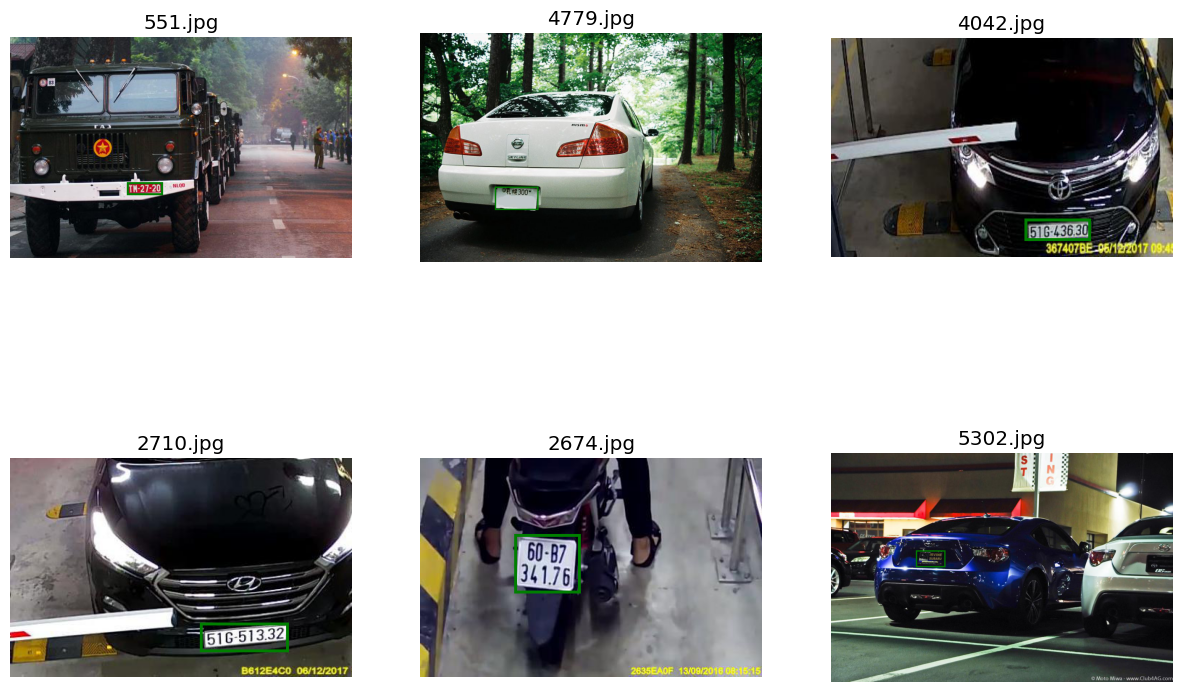

In [18]:
rng = np.random.default_rng(42)
n_cols = 3
n_rows = 2
indexes = rng.choice(len(training), n_cols * n_rows)

plt.figure(figsize=(15, 10))

for ii, id in enumerate(indexes, 1):
    plt.subplot(n_rows, n_cols, ii)
    image = training['image'][int(id)]
    bbox = training['bbox'][int(id)]
    show_image_with_bb(image, bbox)
    plt.title(str(id)+'.jpg')
    plt.axis('off')

## Data Augmentation

In [20]:
class Resize:
    def __init__(self, new_size=(256, 256)):
        self.new_width = new_size[0]
        self.new_height = new_size[1]

    def __call__(self, data):
        image, [x, y, w, h] = data 
        original_width, original_height = image.size
        image_new = tf.resize(image, (self.new_height, self.new_width))
        x_new = x * self.new_width / original_width
        y_new = y * self.new_height / original_height
        w_new = w * self.new_width / original_width
        h_new = h * self.new_height / original_height
        
        bbox_new = [x_new, y_new, w_new, h_new]
        
        return image_new, bbox_new

In [21]:
class ImageAdjustment: # Adjust brightness, contrast and gamma filter
    def __init__(self, p=0.5, brightness=0.8, contrast=0.8, gamma=0.4):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
        self.brightness = brightness
        self.contrast = contrast
        self.gamma = gamma
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        
        if np.random.random() < self.p:
            brightness = 1 + np.random.uniform(-self.brightness, self.brightness)
            image = tf.adjust_brightness(image, brightness)
        
        if np.random.random() < self.p:
            contrast = 1 + np.random.uniform(-self.contrast, self.contrast)
            image = tf.adjust_contrast(image, contrast)
            
        if np.random.random() < self.p:
            gamma = 1 + np.random.uniform(-self.gamma, self.gamma)
            image = tf.adjust_gamma(image, gamma)
        
        bbox_new = [x, y, w, h]
        return image, bbox_new

In [22]:
class ToTensor:
    def __init__(self, scale_label=True):
        self.scale_label = scale_label
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        width, height = image.size
        
        image = tf.to_tensor(image)
        
        if self.scale_label:
            x, y, w, h = x / width, y / height, w / width, h / height
        bbox_new = [x, y, w, h]
        
        bbox_new = torch.tensor(bbox_new, dtype=torch.float32)
        return image, bbox_new

In [23]:
class ToPIL:
    def __init__(self, unscale_label=True):
        self.unscale_label = unscale_label
    
    def __call__(self, data):
        image, [x, y, w, h] = data
        
        image = tf.to_pil_image(image)
        width, heigth = image.size
        
        if self.unscale_label:
            x, y, w, h = x * width, y * heigth, w * width, h * heigth
        bbox_new = [x, y, w, h]
        
        return image, bbox_new

In [24]:
img = training['image'][2674]
bbox = training['bbox'][2674]
transformation = Compose([Resize(), ImageAdjustment(), ToTensor()])
new_image, bbox_new = transformation((img, bbox))
print(f'new image type {new_image.dtype}, shape = {new_image.shape}')

new image type torch.float32, shape = torch.Size([3, 256, 256])


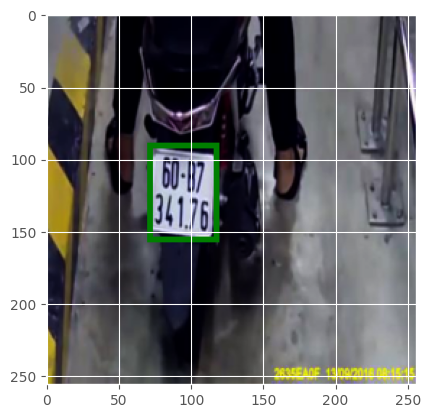

In [25]:
new_image, bbox_new = ToPIL()((new_image, bbox_new))
show_image_with_bb(new_image, bbox_new)

## Data Preparation

In [26]:
class PlateDataset(Dataset):
    def __init__(self, dataset, transformation):
        self.dataset = dataset.reset_index(drop=True)
        self.transformation = transformation
    
    def __getitem__(self, index):
        image = self.dataset.loc[index, 'image']
        bbox = self.dataset.loc[index, 'bbox']
        image, bbox = self.transformation((image, bbox))
        return image.to(device), bbox.to(device)

    def __len__(self):
        return len(self.dataset)

In [27]:
train_transformation = Compose([Resize(), ImageAdjustment(), ToTensor()])
val_transformaion = Compose([Resize(), ToTensor()])

train_dataset = PlateDataset(training, train_transformation)
val_dataset = PlateDataset(validation, val_transformaion)

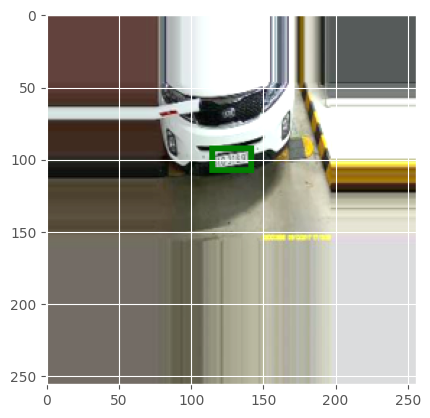

In [28]:
image, bbox = train_dataset[34]
show_image_with_bb(*ToPIL()((image, bbox)))

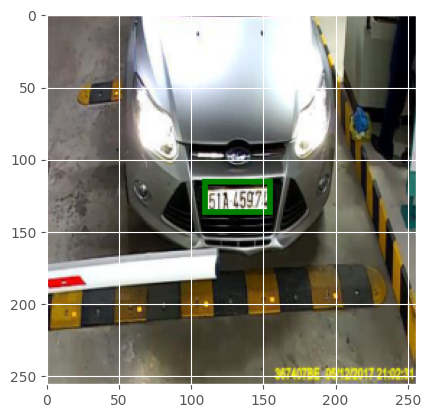

In [29]:
image, bbox = val_dataset[34]
show_image_with_bb(*ToPIL()((image, bbox)))

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [31]:
image_batch, bbox_batch = next(iter(train_dataloader))
print(image_batch.shape, image_batch.dtype)
print(bbox_batch, bbox_batch.dtype)

torch.Size([8, 3, 256, 256]) torch.float32
tensor([[0.2903, 0.4587, 0.0847, 0.0891],
        [0.1599, 0.7193, 0.3027, 0.1637],
        [0.3199, 0.5149, 0.2034, 0.2574],
        [0.5318, 0.4488, 0.1017, 0.0429],
        [0.3453, 0.6898, 0.2267, 0.1320],
        [0.5593, 0.3960, 0.1970, 0.2838],
        [0.3898, 0.2640, 0.1886, 0.2871],
        [0.3333, 0.3689, 0.2233, 0.2222]]) torch.float32


## Data Modelling

In [32]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.base1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True)
        )
        self.base2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    
    def forward(self, x):
        x = self.base1(x) + x
        x = self.base2(x)
        return x

In [33]:
class PlateNet(nn.Module):
    def __init__(self, in_channels, first_output_channels):
        super().__init__()
        self.model = nn.Sequential(
            ResBlock(in_channels, first_output_channels),
            nn.MaxPool2d(2),
            ResBlock(first_output_channels, 2 * first_output_channels),
            nn.MaxPool2d(2),
            # Remove one ResBlock and its corresponding MaxPool2d
            # ResBlock(2 * first_output_channels, 4 * first_output_channels),
            # nn.MaxPool2d(2),
            ResBlock(2 * first_output_channels, 4 * first_output_channels),  # Adjusted layer
            nn.MaxPool2d(2),
            ResBlock(4 * first_output_channels, 8 * first_output_channels),
            nn.MaxPool2d(2),
            nn.Conv2d(8 * first_output_channels, 16 * first_output_channels, kernel_size=3),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(7 * 7 * 16 * first_output_channels, 4)
        )
    
    def forward(self, x):
        return self.model(x)

In [34]:
net = PlateNet(3, 16)

summary(model=net, 
        input_size=(8, 3, 256, 256),
        col_names=['input_size', 'output_size', 'num_params'],
        col_width=20,
        row_settings=['var_names'], device='cpu')

Layer (type (var_name))                  Input Shape          Output Shape         Param #
PlateNet (PlateNet)                      [8, 3, 256, 256]     [8, 4]               --
├─Sequential (model)                     [8, 3, 256, 256]     [8, 4]               --
│    └─ResBlock (0)                      [8, 3, 256, 256]     [8, 16, 256, 256]    --
│    │    └─Sequential (base1)           [8, 3, 256, 256]     [8, 3, 256, 256]     90
│    │    └─Sequential (base2)           [8, 3, 256, 256]     [8, 16, 256, 256]    480
│    └─MaxPool2d (1)                     [8, 16, 256, 256]    [8, 16, 128, 128]    --
│    └─ResBlock (2)                      [8, 16, 128, 128]    [8, 32, 128, 128]    --
│    │    └─Sequential (base1)           [8, 16, 128, 128]    [8, 16, 128, 128]    2,352
│    │    └─Sequential (base2)           [8, 16, 128, 128]    [8, 32, 128, 128]    4,704
│    └─MaxPool2d (3)                     [8, 32, 128, 128]    [8, 32, 64, 64]      --
│    └─ResBlock (4)                      [

In [35]:
loss_func = nn.SmoothL1Loss()

In [36]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [37]:
def centroid_to_bbox(centroids, w=50/256, h=50/256):
    x0_y0 = centroids[:, :2] - torch.tensor([w/2, h/2]).to(device)
    x1_y1 = centroids[:, :2] + torch.tensor([w/2, h/2]).to(device)
    return torch.cat([x0_y0, x1_y1], dim=1)

In [38]:
def iou_batch(output_labels, target_labels):
    output_bbox = centroid_to_bbox(output_labels)
    target_bbox = centroid_to_bbox(target_labels)
    return torch.trace(box_iou(output_bbox, target_bbox)).item()

In [39]:
def batch_loss(loss_func, output, target, optimizer=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        iou_metric = iou_batch(output, target)
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), iou_metric

In [40]:
def train_val_step(dataloader, model, loss_func, optimizer=None):
    if optimizer is not None:
        model.train()
    else:
        model.eval()
    
    running_loss = 0
    running_iou = 0
    
    for image_batch, bbox_batch in dataloader:
        output = model(image_batch)
        loss, iou_metric_value = batch_loss(loss_func, output, bbox_batch, optimizer)
        running_loss += loss
        running_iou += iou_metric_value
    
    return running_loss / len(dataloader.dataset), running_iou / len(dataloader.dataset)

In [37]:
num_epochs = 50
loss_tracking = {'train': [], 'val': []}
iou_tracking = {'train': [], 'val': []}
best_loss = float('inf')

model = PlateNet(3, 16).to(device)
loss_func = nn.SmoothL1Loss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    train_loss, train_iou = train_val_step(train_dataloader, model, loss_func, optimizer)
    loss_tracking['train'].append(train_loss)
    iou_tracking['train'].append(train_iou)
    
    with torch.inference_mode():
        val_loss, val_iou = train_val_step(val_dataloader, model, loss_func)
        loss_tracking['val'].append(val_loss)
        iou_tracking['val'].append(val_iou)
        if val_loss < best_loss:
            best_loss = val_loss
            print('Saving best model')
            torch.save(model.state_dict(), 'best_model.pt')
            best_loss = val_loss
    print(f'Training loss: {train_loss: .6}, IoU: {train_iou: .2}')
    print(f'Validation loss: {val_loss: .6}, IoU: {val_iou: .2}')

Epoch 1/50
Saving best model
Training loss:  0.0462015, IoU:  0.16
Validation loss:  0.0230264, IoU:  0.24
Epoch 2/50
Saving best model
Training loss:  0.0213592, IoU:  0.24
Validation loss:  0.016392, IoU:  0.31
Epoch 3/50
Training loss:  0.0168136, IoU:  0.28
Validation loss:  0.0170495, IoU:  0.26
Epoch 4/50
Saving best model
Training loss:  0.0144085, IoU:  0.31
Validation loss:  0.0149411, IoU:  0.29
Epoch 5/50
Saving best model
Training loss:  0.0130021, IoU:  0.32
Validation loss:  0.011894, IoU:  0.36
Epoch 6/50
Training loss:  0.0118991, IoU:  0.34
Validation loss:  0.0125834, IoU:  0.35
Epoch 7/50
Saving best model
Training loss:  0.0112774, IoU:  0.35
Validation loss:  0.0117501, IoU:  0.36
Epoch 8/50
Training loss:  0.0105003, IoU:  0.36
Validation loss:  0.0122602, IoU:  0.31
Epoch 9/50
Saving best model
Training loss:  0.00956259, IoU:  0.38
Validation loss:  0.0108793, IoU:  0.4
Epoch 10/50
Saving best model
Training loss:  0.00886771, IoU:  0.39
Validation loss:  0.0102

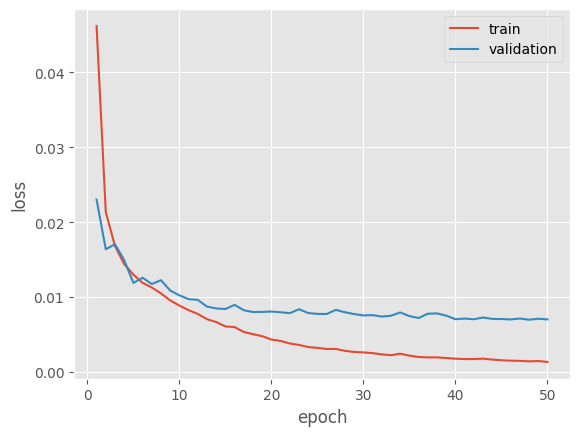

In [38]:
plt.plot(range(1, num_epochs+1), loss_tracking['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_tracking['val'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

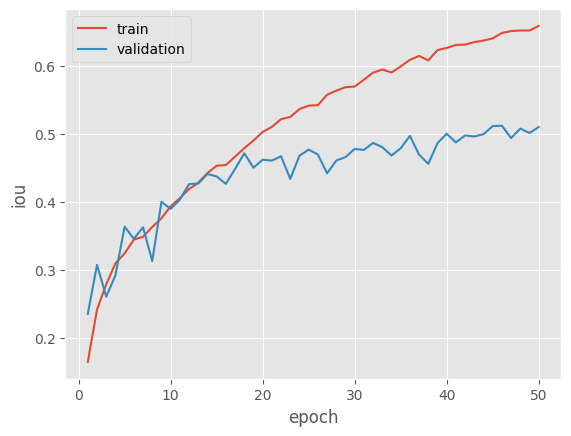

In [39]:
plt.plot(range(1, num_epochs+1), iou_tracking['train'], label='train')
plt.plot(range(1, num_epochs+1), iou_tracking['val'], label='validation')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.legend()

In [41]:
def show_image_with_2_bb(img, bbox, target_bbox):
    image = img
    [x, y, w, h] = bbox
    [x_target, y_target, w_target, h_target] = target_bbox
    ImageDraw.Draw(image).rectangle([(x, y), (x+w, y+h)], outline='green', width=4)
    ImageDraw.Draw(image).rectangle([(x_target, y_target), (x_target+w_target, y_target+h_target)], outline='red', width=4)
    plt.imshow(image, aspect='equal')

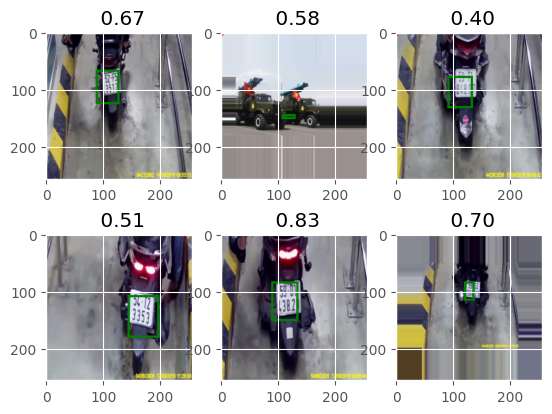

In [42]:
model = PlateNet(3, 16).to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=torch.device('cpu')))
model.eval()
rng = np.random.default_rng(0)
n_rows = 2
n_cols = 3
indexes = rng.choice(len(val_dataset), n_rows * n_cols, replace=False)

for ii, id in enumerate(indexes, 1):
    image, bbox = val_dataset[id]
    output = model(image.unsqueeze(0))
    iou = iou_batch(output, bbox.unsqueeze(0))
    _, label = ToPIL()((image, bbox))
    image, output = ToPIL()((image, output.squeeze()))
    plt.subplot(n_rows, n_cols, ii)
    show_image_with_2_bb(image, output, bbox)
    plt.title(f'{iou: .2f}')